In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import spacy
nlp = spacy.load('en_core_web_lg')

import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('amazon_ten_topic_data.csv', names=['ad'])
df.dropna(inplace=True)
df = df.sample(frac=1)
df.describe()

,ad
count,10000
unique,9934
top,USB Printer with 3 Year Printer Warranty
freq,6


In [4]:
ads = pd.DataFrame(df['ad'].unique(), columns = ['ad'])
ads.tail()

,ad
9929,James Jeans Women's James Twiggy Ankle 5-Pocke...
9930,mDesign Modern Round Metal Small Trash Can Was...
9931,"Ted Baker London Women's Low-Top, Beige (Nude/..."
9932,"Philips 221B8LJEB 21.5"" Monitor, Full HD 1920x..."
9933,Canon MG7720 Wireless All-In-One Printer with ...


In [5]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

print(get_num_words_per_sample(ads['ad']))

11.0


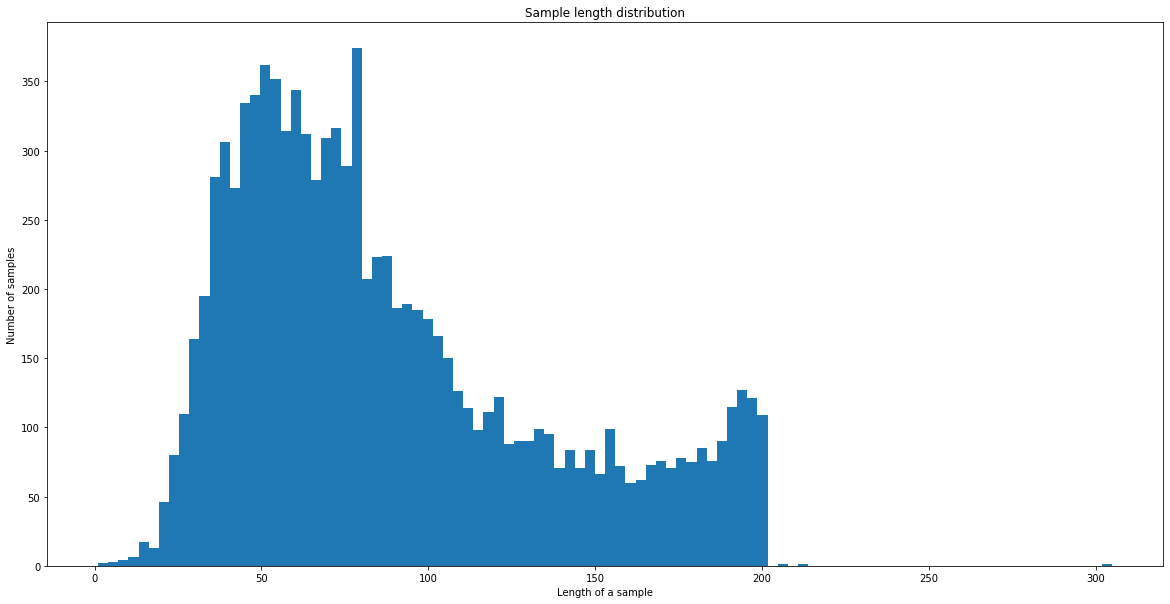

In [6]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    
    plt.figure(figsize=(20,10))
    plt.hist([len(s) for s in sample_texts], 100)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()
    

plot_sample_length_distribution(ads['ad'])

### Removing stopwords 

In [7]:
def stopwords(text):
    """
    Function for removing 
        - stopwords,
        - punctuation,
        - numbers / digits
        - words containing numbers
    """
    doc = nlp(text)
    for token in doc:
        text = [token.text for token in doc if 
                not token.is_stop 
                and not token.is_punct 
                and not token.is_digit]
        
        
    # joining the list of words with space separator
    joined_text = " ".join(text)
    # removing words that contain any sort of numbers, like 'G2420-BK' or 'G1W40A#BGJ '
    re_text = re.sub(r"\S*\d\S*", '', joined_text).strip()
    
    return re_text


ads['SW'] = ads['ad'].apply(stopwords)
ads.head()

,ad,SW
0,"Puma Women's Low-Top, Black-Teal Green 09, 8.5 us",Puma Women Low Black Teal Green
1,Pataugas Women's Jester/N F2e N Trainers,Pataugas Women Jester N N Trainers
2,Fashion Supre.me Backpack Unisex Casual Colleg...,Fashion Supre.me Backpack Unisex Casual Colleg...
3,HP Officejet 6600 e-All-in-One Wireless Color ...,HP Officejet e Wireless Color Photo Printer Sc...
4,BRTMFCJ410W - Brother MFC-J410W Wireless Compa...,Brother MFC Wireless Compact Inkjet Printer


In [8]:
ads['SW']=ads['SW'].str.replace("  "," ")

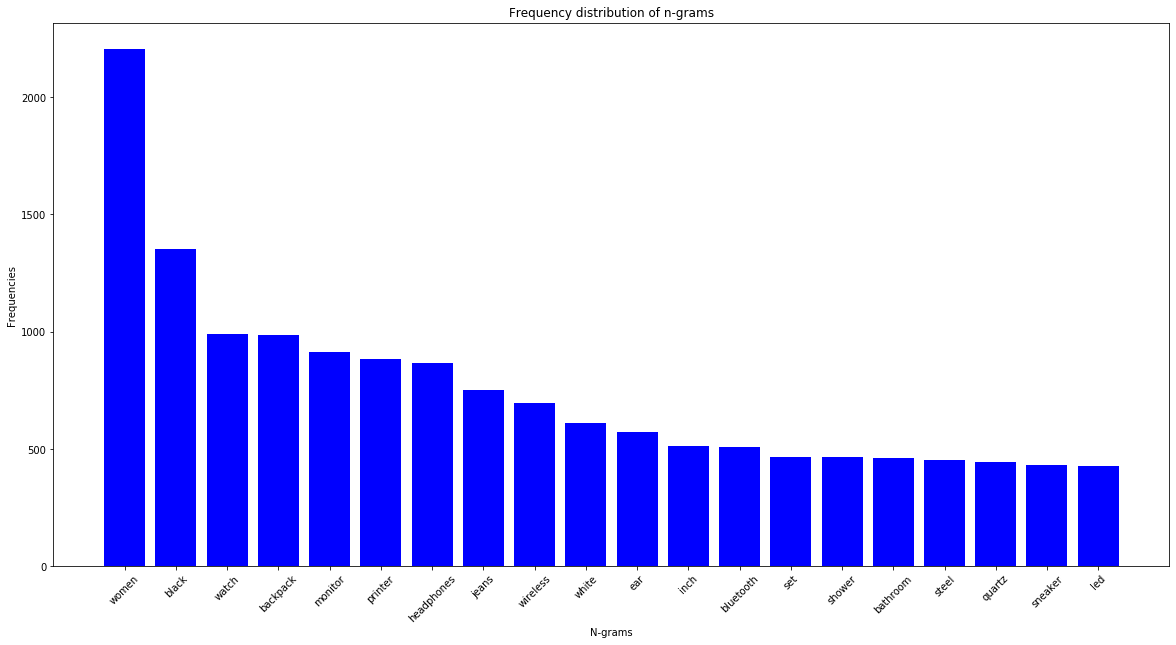

In [9]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 1),
                                          num_ngrams=20):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(20,10))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()
    
    
plot_frequency_distribution_of_ngrams(ads['SW'])

In [79]:
tfidf = TfidfVectorizer(max_df=0.95)

dtm = tfidf.fit_transform(ads.SW.values)

dtm.shape

(9934, 11581)

In [82]:
print(dtm)

  (0, 4195)	0.46320630049189715
  (0, 10050)	0.5708418204294092
  (0, 1036)	0.2423205443763445
  (0, 5924)	0.37861837164968376
  (0, 11272)	0.20037846320495828
  (0, 8015)	0.4662155007499875
  (1, 10415)	0.3801123900991622
  (1, 5122)	0.6419206925052615
  (1, 7410)	0.6419206925052615
  (1, 11272)	0.17717285333886024
  (2, 7132)	0.333188125835371
  (2, 1102)	0.16346986768088015
  (2, 7618)	0.19379630551365726
  (2, 6282)	0.1826315886972096
  (2, 8786)	0.17663134523746982
  (2, 10440)	0.17501689622001979
  (2, 5756)	0.20222823889550062
  (2, 2055)	0.21595981701689948
  (2, 1671)	0.18574414453340374
  (2, 10698)	0.1926335357432616
  (2, 704)	0.5222258455440136
  (2, 6237)	0.359380103223345
  (2, 9861)	0.359380103223345
  (2, 3502)	0.17416452092335227
  (2, 11272)	0.09496169267974168
  :	:
  (9932, 2781)	0.2747141744410618
  (9932, 9443)	0.2640225282938187
  (9932, 10742)	0.2008543945237217
  (9932, 4675)	0.2581025655171951
  (9932, 120)	0.22793033780347974
  (9932, 3102)	0.292288795746827

### NEAREST NEIGNBOR SEARCH

In [85]:
tfidf = TfidfVectorizer().fit_transform(ads['SW'])

tfidf.shape

(9934, 11581)

In [86]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(tfidf)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [87]:
knn.kneighbors(features[0:1], return_distance=False)

array([[   0, 3801, 1084, 8259, 5864, 1936,  227, 2689, 1522, 2264]])

In [88]:
knn.kneighbors(features[0:1], return_distance=True)

(array([[0.        , 0.32207704, 0.36686471, 0.46181979, 0.48400344,
         0.53133521, 0.5481793 , 0.55724627, 0.60624022, 0.61672622]]),
 array([[   0, 3801, 1084, 8259, 5864, 1936,  227, 2689, 1522, 2264]]))

In [98]:
input_ad = ['Canon CanoScan Lide 300 Scanner', "Puma 19.5"" The Pace Backpack - Camouflage/Orange with Laptop Sleeve Back Pack"]
input_features = vec.transform(input_ad)

In [99]:
D, N = knn.kneighbors(input_features, n_neighbors=2, return_distance=True)

for input_text, distances, neighbors in zip(input_ad, D, N):
    print("Input text = ", input_text[:200], "\n")
    for dist, neighbor_idx in zip(distances, neighbors):
        print("Distance = ", dist, "Neighbor idx = ", neighbor_idx)
        print(ads['SW'][neighbor_idx][:200])
        print("-"*200)
    print("="*200)
    print()

Input text =  Canon CanoScan Lide 300 Scanner 

Distance =  0.4164815441813312 Neighbor idx =  2344
Canon PIXMA Wireless Color Printer Scanner Copier
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.458113431547595 Neighbor idx =  3179
Canon imageCLASS Monochrome Laser Printer Scanner Copier
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Input text =  Puma 19.5 The Pace Backpack - Camouflage/Orange with Laptop Sleeve Back Pack 

Distance =  0.734900029021486 Neighbor idx =  4589
Puma Unisex Layered Print Backpack Adult Camouflage OS
--------------------------------------------------------------------------------------------------------------------------------------------